# Learning covariance dictionaries on simulated data

In [1]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
import covdict
import sys
import time
from numpy import (arange, argmax, argsort, corrcoef, cov, diag, diag_indices, dot, dstack, empty, floor, 
                   hsplit, hstack, max, roll, triu_indices, vstack, zeros)
from numpy.linalg import norm
from numpy.random import multivariate_normal, rand, randn
from scipy.linalg import eigh

## Simulate covariance matrices evolving over time

#### Generate random covariance dictionary and weights

In [161]:
n = 25 # number of neurons
k = 2 # number of dictionary elements
N = 50 # number of samples

# Generate random dictionary and weights
X_unpacked, D, W = covdict.generate_data(n, k, N)

#### Run ALS and plot objective per iteration

In [162]:
reload(covdict)
als = covdict.CovarianceDictionary(k=k, method='als', obj_tol=1e-3, verbose=True, time=True, nls_beta=0.7, psdls_beta=0.7)
t = time.time()
Wals = als.fit_transform(X_unpacked, is_unpacked=True)
print str(time.time() - t) + ' seconds'

Initial gradient norm: 4.799237.
Iter: 0. Projected gradient norm: 3.309424. Objective: 0.065891.
Iter: 1. Projected gradient norm: 0.000060. Objective: 0.041908.
Iter: 2. Projected gradient norm: 0.000061. Objective: 0.028170.
Iter: 3. Projected gradient norm: 0.000064. Objective: 0.021500.
Iter: 4. Projected gradient norm: 0.000057. Objective: 0.017857.
Iter: 5. Projected gradient norm: 0.000058. Objective: 0.014684.
Iter: 6. Projected gradient norm: 0.000060. Objective: 0.011990.
Iter: 7. Projected gradient norm: 0.000058. Objective: 0.009765.
Iter: 8. Projected gradient norm: 0.000057. Objective: 0.007974.
Iter: 9. Projected gradient norm: 0.000062. Objective: 0.006564.
Iter: 10. Projected gradient norm: 0.000057. Objective: 0.005478.
Iter: 11. Projected gradient norm: 0.000058. Objective: 0.004626.
Iter: 12. Projected gradient norm: 0.000064. Objective: 0.003953.
Iter: 13. Projected gradient norm: 0.000060. Objective: 0.003405.
Iter: 14. Projected gradient norm: 0.000063. Objectiv

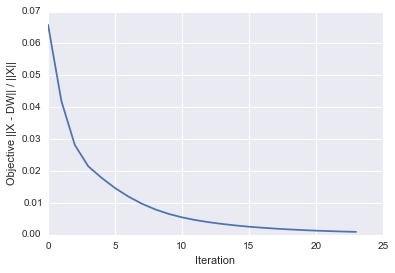

In [163]:
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4));

plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');
# plt.savefig('sim_als.png');

#### Run ADMM and plot objective per iteration

In [165]:
reload(covdict)
admm = covdict.CovarianceDictionary(k=k, method='admm', obj_tol=1e-3, verbose=True, time=True, admm_gamma=0.1)
t = time.time()
Wadmm = admm.fit_transform(X_unpacked, is_unpacked=True)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.065891.
Iter: 100. Objective: 0.046036.
Iter: 200. Objective: 0.031957.
Iter: 300. Objective: 0.019082.
Iter: 400. Objective: 0.009268.
Iter: 500. Objective: 0.003394.
Iter: 600. Objective: 0.001269.
Iter: 630. Objective: 0.000996.
0.766593933105 seconds


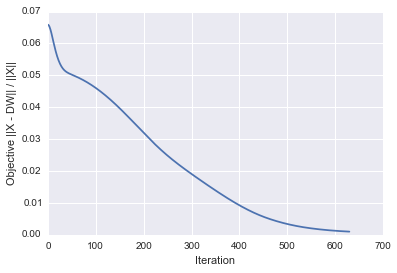

In [166]:
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4));

plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');
# plt.savefig('sim_admm.png');

## Compare runtime and accuracy of ALS, ADMM, and PGM

In [209]:
reload(covdict)
n_trials = 100 # trials per problem size 
n = 25 # 25, 50, 100
k = 2 # 2, 4, 8
N = 50 # 50, 100, 200
obj_tol = 1e-2 # 5e-2, 1e-2, 1e-3
methods = ['als', 'admm', 'pgm']

times = empty((len(methods), n_trials))
sim = empty((len(methods), n_trials))


for method_idx in range(len(methods)):
    for trial_idx in range(n_trials):
        X_unpacked, D, W = covdict.generate_data(n, k, N)
        cd = covdict.CovarianceDictionary(k=k, method=methods[method_idx], obj_tol=obj_tol, admm_alpha=0.1, nls_beta=0.5, psdls_beta=0.5)
        t = time.time()
        cd.fit_transform(X_unpacked, is_unpacked=True)
        times[method_idx, trial_idx] = time.time() - t
        sim[method_idx, trial_idx] = covdict.eval_similarity(D, cd.dictionary)
    print "%s: %f seconds, accuracy %f" %(methods[method_idx], np.mean(times[method_idx, :]), np.mean(sim[method_idx, :]))

als: 26.406387, 0.996808
admm: 0.067753, 0.998764
pgm: 1.730071, 0.991747
